Contents:
1.  PCA and SVM
2. T-SNE visualiztion 

In [0]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import svm

In [0]:
#get training data
df = pd.read_csv('./drive/My Drive/Colab Notebooks/csci3202/train.csv')
df_test = pd.read_csv('./drive/My Drive/Colab Notebooks/csci3202/test.csv')
X = df.iloc[:, 1:-2]  #remove PID and labels from df - training
y = df.iloc[:, -1]    #y labels - training

In [0]:
#X.head()

In [0]:
#y.head()

## PCA 

In [0]:
#mean center input data for PCA
Xs = preprocessing.scale(X, with_std=False)  #mean center to 0, but do not scale 
#np.mean(Xs[:,0])  #confirm mean centering worked


In [6]:
#define PCA object
pca = PCA(.99)  #get main components which account 0.99 of explanation
X_reduced = pca.fit_transform(Xs)  
X_reduced.shape  

(997, 6)

In [7]:
pca.explained_variance_ratio_  

array([0.79738873, 0.10534905, 0.0445888 , 0.02368887, 0.01119331,
       0.00900176])

Note: only 6 factors were found to account for 0.99 of occurence; the first PCA accounts for 0.797 

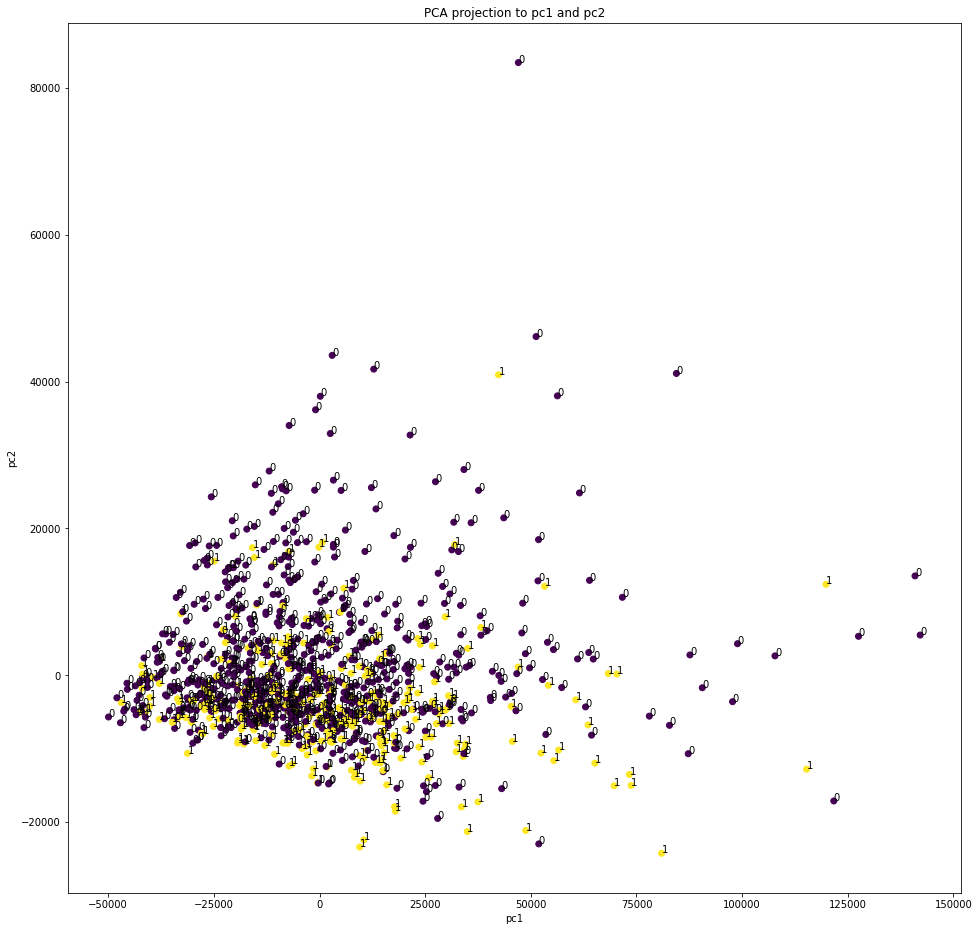

In [8]:
fig = plt.figure(figsize=(16,16))
ax = plt.axes()
ax.scatter(X_reduced[:,0], X_reduced[:,1], c=y)
ax.set_title('PCA projection to pc1 and pc2')
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
for i,t in enumerate(y):
    ax.text(X_reduced[i, 0], X_reduced[i,1], '%s' %t , size =10)  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'pc2')

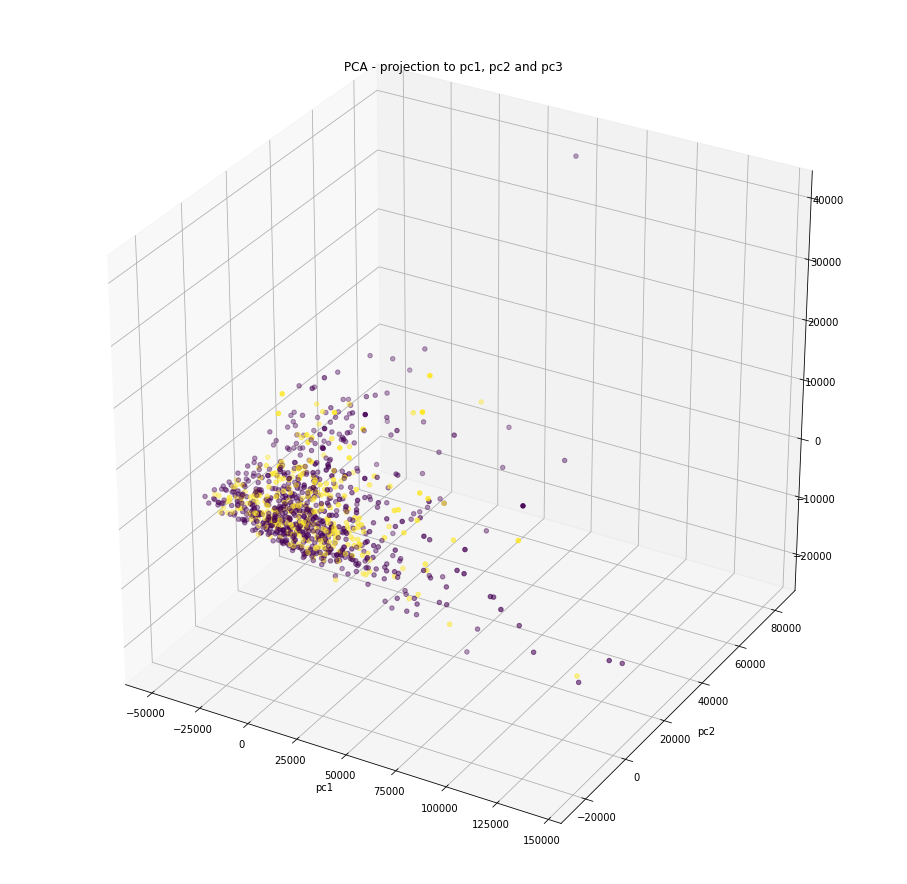

In [9]:
fig = plt.figure(figsize=(16,16))
ax = plt.axes()
ax = plt.axes(projection='3d')
ax.scatter(X_reduced[:,0], X_reduced[:,1], X_reduced[:,2], c=y)
ax.set_title('PCA - projection to pc1, pc2 and pc3')
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')

#for i,t in enumerate(y):
#    ax.text(X_reduced[i, 0], X_reduced[i,1], X_reduced[i,2], '%s' %t , size =10)  

**Summary** - PCA preprocessing summary - Projecting transformed data onto 2 and 3 dimensions do not seem to seem to show any clear separation boundaries.

## SVM - rbf kernel

In [10]:
#preparation of the SVM model using PCA transformed data
xtrain, xval, ytrain, yval = train_test_split(X_reduced, y, test_size = .10)
#clf = svm.NuSVC(gamma='auto', probability=True)

clf = svm.SVC(kernel='rbf', C =1, probability=True)
clf.fit(xtrain, ytrain)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [11]:
acc = clf.score(xval, yval)
print('acc = ', acc)

acc =  0.76


In [12]:
from sklearn import metrics
yhat = clf.predict(xval)
metrics.recall_score(yval, yhat)

0.09523809523809523

In [13]:
#class = clf.predict(xval)
prob = clf.predict_proba(xval)
logloss = metrics.log_loss(yval, prob)
logloss 

0.5253672578612142

**Hyperparameter tuning - C, gamma**


In [14]:
from sklearn.model_selection import cross_val_score, KFold
kf_10 = KFold( n_splits=10, shuffle=True, random_state=1)
#scores = cross_val_score(clf, xtrain, ytrain, cv=5, scoring='f1_macro')
scores = cross_val_score(clf, xtrain, ytrain, cv=kf_10)
scores

array([0.66666667, 0.71111111, 0.63333333, 0.68888889, 0.75555556,
       0.65555556, 0.7       , 0.71910112, 0.78651685, 0.56179775])

In [0]:
acc_list = []
index = [1,5,10,15,20,25,30,50,100]
for i in index:
    clf = svm.SVC(kernel='rbf', C= i, probability=True)
    #clf.fit(xtrain, ytrain)
    acc = cross_val_score(clf, xtrain, ytrain, cv=kf_10).mean()
    #acc = clf.score(xval, yval)
    acc_list.append(acc)


Text(0, 0.5, 'accuracy')

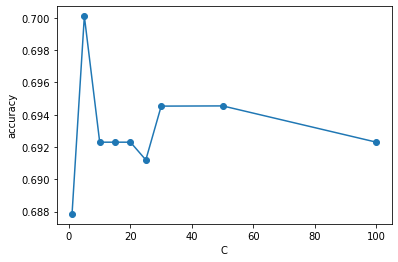

In [16]:
plt.plot(index, acc_list, marker= 'o')
plt.xlabel('C')
plt.ylabel('accuracy')

In [0]:
acc_list = []
index = [.1, 1, 10, 50]
for i in index:
    clf = svm.SVC(kernel='rbf', C= 1, probability=True, gamma= i)
    #clf.fit(xtrain, ytrain)
    acc = cross_val_score(clf, xtrain, ytrain, cv=kf_10).mean()
    #acc = clf.score(xval, yval)
    acc_list.append(acc)


Text(0, 0.5, 'accuracy')

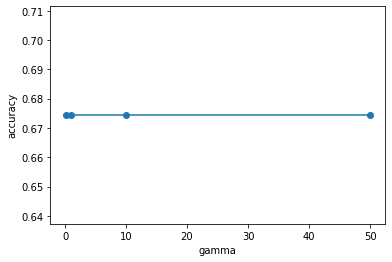

In [18]:
plt.plot(index, acc_list, marker= 'o')
plt.xlabel('gamma')
plt.ylabel('accuracy')

**Summary** - A non linear kernel, rbf, was chosen since there was no linear boundaries of separation in the pca plots.  This appears to be a difficult problem as there was no obvious means of separation.  The no-stent and stent data points were mixed throughout the pca plot.  The SVM classifier reported an accuracy of approximately 0.73, a log loss of 0.58, and a recall of 0.10.  It is not particularly good at predicting when a stent is needed with recall of 0.10.  It only predicts correctly 10% of the time when a stent is required.  The hyperparameter search of C and gamma were inconclusive.  There were no strong trends either way.  C is the penalty parameter of the error. Higher values can lead to overfitting .  Gamma is a parameter for non linear hyperplanes.  Higher gamma values helps to exactly fit the training data set, but again can lead to overfitting.  

## T-SNE visualization

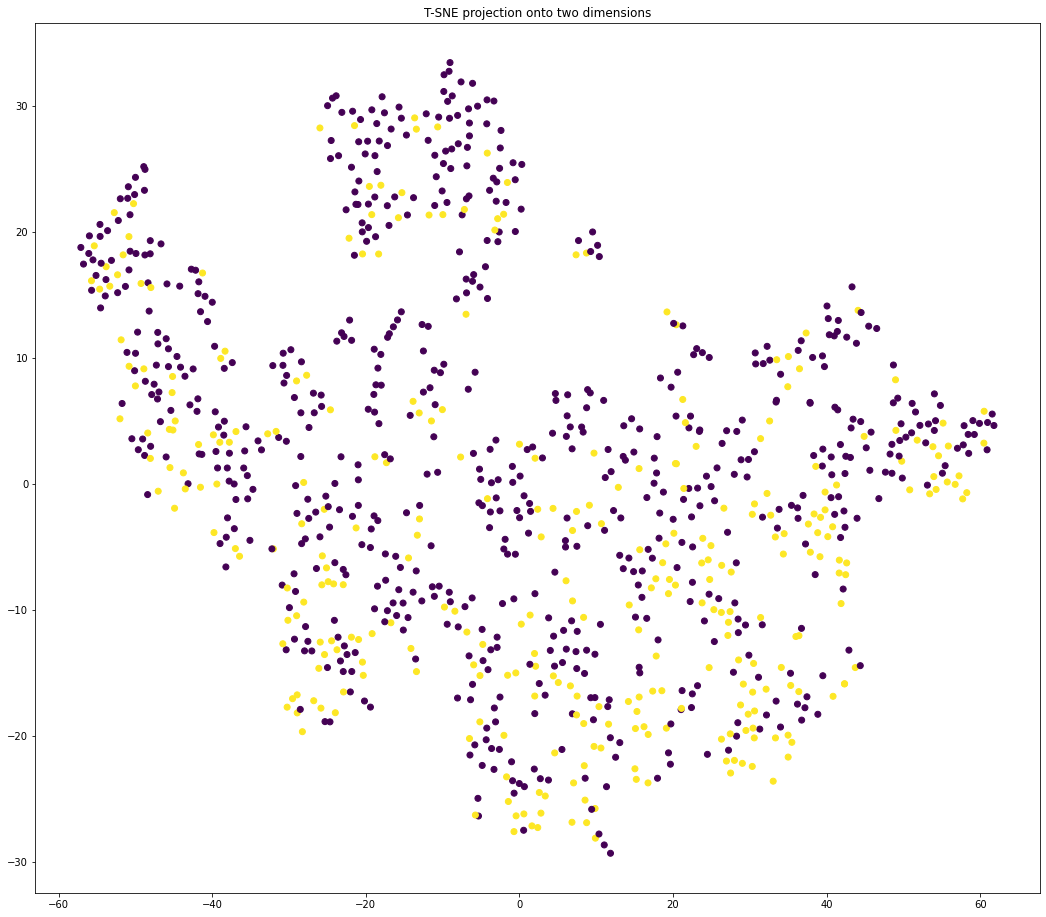

In [19]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components = 2).fit_transform(Xs)

fig  = plt.figure(figsize=(18, 16))
ax = plt.axes()
ax.set_title('T-SNE projection onto two dimensions')
ax.scatter(X_tsne[:, 0], X_tsne[:,1], c = y.astype(np.int))


**Summary** - T-SNE (t distribution stochasic neigbor embedding) is another method like PCA to project high dimensional data set to a lower one but it is better when the data set lives in a manifold like structure such as a cylinder or ball.   However, the results, do not show any obvious boundaries of separation just as in the case of the PCA.  